In [6]:
import json
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [7]:
#legacy
def get_f1_report(filename):
    
    with open(filename) as f:
        result = json.load(f)
    result = result['result']
    total_counts = len(result)
    
    # throw away non-standard
    new_result = [_ for _ in result if _[0] in ['contradiction', 'entailment']]
    throw_away = len(result) - len(new_result)
    
    y0 = [x[0] for x in new_result]
    y_true = [x[1] for x in new_result]

    report = classification_report(y_true, y0, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    return df_classification_report, throw_away, total_counts

# fname = "code/results/eval_{}_result.log"
# method = 'section_base_result'
# fname = f"code/results/{method}.log"
# report, throw_away, total_counts = get_f1_report(fname)
# print(f'{throw_away}/{total_counts} thrown away.')
# report

In [131]:
# generate precision recall scores from logs

def get_precision_recall(result):
    total_counts = len(result)    
    # throw away non-standard
    new_result = [_ for _ in result if _[0] in ['contradiction', 'entailment']]
    throw_away = total_counts - len(new_result)
    
    y0 = [x[0] for x in new_result]
    y_true = [x[1] for x in new_result]

    report = classification_report(y_true, y0, output_dict=True)
    report = pd.DataFrame(report).transpose()
    
    return report['precision']['contradiction'],\
            report['recall']['contradiction'], \
            report['f1-score']['contradiction'],\
            report['precision']['entailment'], \
            report['recall']['entailment'],\
            report['f1-score']['entailment'],\
            report['f1-score']['accuracy'],\
            throw_away,\
            total_counts

In [97]:
# Display Name to filename 
large_data = {
    "Base": "base-large",
    "SecR.": "section-retrieval-large",
    "SUM.": "summarization-large",
    "TRNC.": "truncation-large",
    "TOPK": "topk-large",
    "SW.": "sliding-window-large"
}

In [98]:
xl_data = {
    "Base": "base-xl",
    "SecR.": "section-retrieval-xl",
    "SUM.": "summarization-xl",
    "TRNC.": "truncation-xl",
    "TOPK": "topk-xl",
    "SW.": "sliding-window-xl"
}

# Prepare metrics

In [99]:
# aggregate data

large_entailment = {}
large_contradiction = {}
xl_entailment = {}
xl_contradiction = {}

for k, v in large_data.items():
    with open(f'f1_calculation/{v}.log', 'r') as f:
        result = json.load(f)

    pr_contra, recall_contra, f1_contra, pr_entail, \
    recall_entail, f1_entail, accuracy, throw_away, total_counts = get_precision_recall(result['result'])

    large_entailment[k] = {
        "precision": pr_entail, "recall": recall_entail, "f1": f1_entail
    }
    large_contradiction[k] = {
        "precision": pr_contra, "recall": recall_contra, "f1": f1_contra
    }

for k, v in xl_data.items():
    with open(f'f1_calculation/{v}.log', 'r') as f:
        result = json.load(f)

    pr_contra, recall_contra, f1_contra, pr_entail, \
    recall_entail, f1_entail, accuracy, throw_away, total_counts = get_precision_recall(result['result'])

    xl_entailment[k] = {
        "precision": pr_entail, "recall": recall_entail, "f1": f1_entail
    }
    xl_contradiction[k] = {
        "precision": pr_contra, "recall": recall_contra, "f1": f1_contra
    }


In [132]:
# test
plot_data_entail = pd.DataFrame(xl_entailment).transpose()[['precision', 'recall']]
plot_data_contra = pd.DataFrame(xl_contradiction).transpose()[['precision', 'recall']]
plot_data_entail # (model, method, x, y, marker, color, alpha, annotation, annotation_x, annotation_y)

,precision,recall
Base,0.595238,0.750000
SecR.,0.617188,0.790000
SUM.,0.581633,0.587629
TRNC.,0.600000,0.787879
TOPK,0.623932,0.730000
SW.,0.601852,0.656566


In [133]:
# add points to plot data array for (model_size, label_class)

plot_data = []
for data in [["large", "entailment", large_entailment],
        ["large", "contradiction", large_contradiction],
        ["xl", "entailment", xl_entailment],
        ["xl", "contradiction", xl_contradiction]]:
    
    _class = data[1]
    _model = data[0]
    
    for method, values in data[2].items():
        x = values['recall']
        y = values['precision']
        # legacy
        legend = _class.capitalize() + "@" + _model.upper()
        # marker
        marker = "s" if _class == 'entailment' else "o"

        # color
        color = '#d31e32' if _model == 'xl' else "#434343"  # SFU red or grey
        alpha = 1.0 if _model == 'xl' else 0.5
        
        # annotation text and locations
        annotation = method
        if _model == 'xl':
            annotation_x = x + 0.01
            annotation_y = y
        else:
            annotation_x = x 
            annotation_y = y - 0.01

        # handle overlap
        if _model == 'large' and method == 'TRNC.':
            annotation_x -= 0.05
        
        plot_data.append({
            'method': method,
            'class': _class,
            'mode': _model,
            "x": x, "y": y, 
            "marker": marker, "color": color, "alpha": alpha, 
            "annotation": annotation,"legend": legend,
            "annotation_x": annotation_x, "annotation_y": annotation_y
        })

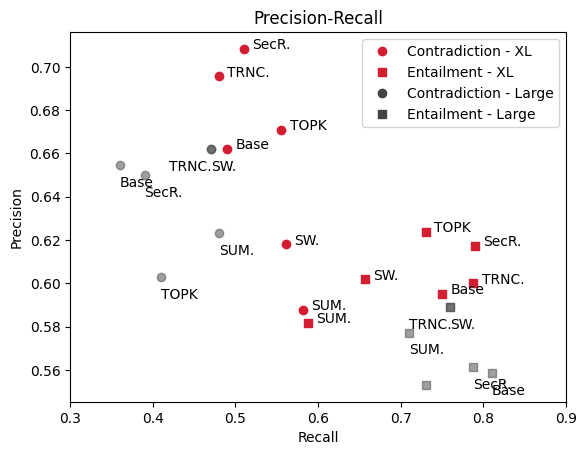

In [134]:
fig, ax = plt.subplots()

for d in plot_data:
    ax.scatter(d['x'], d['y'], color=d['color'], marker=d['marker'], alpha=d['alpha'])
    ax.annotate(d['annotation'], (d['annotation_x'], d['annotation_y']))

# add manual legends
colors = [('#d31e32', "o"), ('#d31e32', "s"), ("#434343", "o"), ("#434343", "s")]
lines = [Line2D([0], [0], color=c[0], marker=c[1], linestyle='None') for c in colors]
labels = ['Contradiction - XL', "Entailment - XL", "Contradiction - Large", "Entailment - Large"]
plt.legend(lines, labels)

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall')
plt.xlim((0.3, 0.9)) 
# plt.ylim((0, 0.8)) 
plt.show()
# plt.savefig('Precision-Recall Curve.png', dpi=300)